# Daily run script to generate playlists followers reports

### 0. Import libraries

In [291]:
import sys
sys.path.append("../../")

from src.common.spotify_auth import sp
from src.common.config import setup_logger

from spotipy import Spotify
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns

### 1. Custom functions

In [292]:
def get_follower_data(sp: Spotify) -> pd.DataFrame:
    playlists = sp.current_user_playlists()
    data = {}

    for playlist in playlists['items']:
        name = playlist['name']
        playlist_id = playlist['id']
        
        # Pobranie pełnych danych o playliście, aby uzyskać liczbę followersów
        playlist_details = sp.playlist(playlist_id)
        followers = playlist_details['followers']['total']
        
        data.update({name : followers})
      
    data_df = pd.DataFrame(data = [data])
    data_df.index = [date.today().strftime("%Y-%m-%d")]

    return data_df

In [293]:
def update_the_historical_data(data_df: pd.DataFrame, csv_url: str = "../data/follower_count.csv") -> pd.DataFrame:
    
    hist_df = pd.read_csv(csv_url, index_col = 0)
    
    hist_df.index = pd.to_datetime(hist_df.index).strftime("%Y-%m-%d")
    
    try:
        updated_df = pd.concat([hist_df, data_df], verify_integrity=True)
        
        updated_df.to_csv(csv_url)
    
    except ValueError:
        common_indexes = hist_df.index.intersection(data_df.index)
        hist_df = hist_df.drop(index=common_indexes)
        updated_df = pd.concat([hist_df, data_df], verify_integrity=True)
        updated_df.to_csv(csv_url)

    
    return updated_df

In [294]:
def create_followers_report(followers_df: pd.DataFrame):
    sns.set_style("dark", {"grid.color": "#2A2A2A"})  # Drobna, ciemnoszara siatka
    plt.style.use('dark_background')
    sns.set_palette("viridis")

    # Tworzenie wykresu
    fig, ax = plt.subplots(figsize=(5, 3))

    # Linia w stylu minimalistycznym
    sns.lineplot(data=followers_df['HOT RAP HITS🔥🎧'], ax=ax, color='#7CFC00', linewidth=2)

    # Dostosowanie osi i wyglądu
    ax.set_ylabel("", fontsize=5, color='white')
    ax.tick_params(axis='x', rotation=45, labelcolor='white')
    ax.tick_params(axis='y', labelcolor='white')

    # Drobne siatki w tle
    ax.grid(color='#2A2A2A', linestyle='-', linewidth=0.5)

    # Usunięcie nadmiarowych ramek
    sns.despine(left=True, bottom=True)

    # Zapis do pliku PNG
    plt.tight_layout()
    plt.show()

### 2. Envinroment variables

In [295]:
sp = Spotify(auth = "BQCprZrBMz9NJD6nNo_m8gaNcm6a0F_Ku3Prb4YHwNYFxkSotsBLWF7Ix-y6j2PDkkAwljHBMklToWPopPnQVVhCCGbhDeZ88Az9-AoWgqrUyBM1q0MhtuvkEoOVu6GC5ur4ptklQOIUgRnFWi9gtLildB88um7STAaIxoVQoVP1-IgeBJIggOakrU1nG8Mwu1lhyNqAf9hx8y44f6WtGuKQPHDhZPdHAYfWrNL89ajLXPvgCNPNqD9k-cbEgh-jGfC2SfsBBDSBl9aNH-uA_aq0d42NPTb0q9fGB79Vg2ccaq1zIdkugxkTwYUAofBmacW0mt4")

In [296]:
df = get_follower_data(sp)


In [302]:
updated_df = update_the_historical_data(df)

In [298]:
updated_df

,DAILY TOP 50,DAILY TOP 100,DAILY TOP 200,Techno French 2025,Edm,Europop summer dancefloor 🪩,LET OUT INNER DEMONS🔥😈,CHILL RAP SONGS,HOT RAP HITS🔥🎧,Hardcore Workout Motivation💪🏼,Sad music to listen to when you're feelin down
2025-05-03,0,0,4,1,0,15,764,4678,40,9,1603
2025-05-06,0,0,4,1,0,15,767,4698,40,9,1603
2025-05-08,0,0,4,2,0,15,761,4720,40,9,1603
2025-05-09,0,0,5,1,0,15,768,4710,40,9,1603
2025-05-10,0,0,4,1,0,15,745,4709,41,9,1603
2025-05-11,0,0,4,1,0,15,743,4702,40,9,1603
2025-05-12,0,0,4,1,0,15,76,4710,46,9,1603
2025-05-14,0,0,4,1,0,15,759,4709,40,9,1603


2025-05-14 07:25:17 | INFO | followers_reporting.py | Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.

2025-05-14 07:25:17 | INFO | followers_reporting.py | Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.



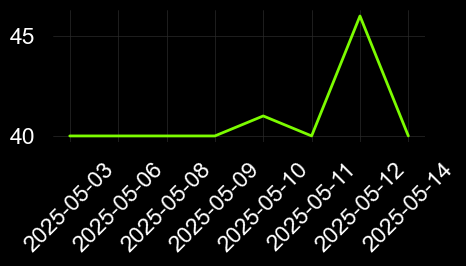

In [299]:
create_followers_report(updated_df)

### 3. Run the code

In [300]:
logger = setup_logger("followers_reporting.py")
logger.info('Starting job initialization.')

2025-05-14 07:25:17 | INFO | followers_reporting.py | Starting job initialization.

